# Q-learning

Obviously, this name comes form the $Q$ function, which we are trying to figure out. This method is very similar to SARSA, the only difference is that, instead of using $R_t + \gamma*Q(s_{t+1}, a_{t+1})$ as the bootstrap estimate it uses $R_t + \gamma*max_{a \in A}Q(s_{t+1}, a)$. This means the update doesn't really care about what the agent is doing(its policy) but just about what it believes would be the best thing to do(the greedy action according to a no exploration policy), for this reason, this is called an "off-policy" method. The learning rule is:



$$ Q_(s_t, a_t) \leftarrow Q(s_{t}, a_{t}) + \alpha(R_t + \gamma*max_{a \in A}Q(s_{t+1}, a) - Q(s_{t}, a_{t}))$$



Again after updating the $Q$ function, we will update our policy, take a new action based on this policy and repeat the process. Notice that although the policy doesn't matter for update rule, it still dictates what actions the agent will take; So it will affect learning since he can only improve over actions he actually takes.



This is also very simple to implement so I won't go through the details in the notebook; you can directly check how the class is implemented on the code base, it should be pretty easy to understand.

In [1]:
import sys

sys.path.append("../../..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import time

from grid_world.action import Action
from grid_world.grid_world import GridWorld
from grid_world.agents.q_agent import QAgent
from grid_world.visualization.format_objects import (
    get_policy_rec_str,
    get_policy_eval_str,
    get_world_str,
)
from grid_world.agents.commons.dacaying_functions import get_linear_decay, get_exp_decay
from grid_world.utils.returns import returns_from_reward
from grid_world.utils.policy import get_policy_rec, get_random_policy, sample_action
from notebooks.utils.experimentation import get_exp_results, get_results, moving_average, get_summary_df
from notebooks.utils.worlds import small_world_03, large_world_02
from notebooks.utils.basics import basic_actions, basic_reward

np.random.seed(13)

## Small World

We will start by exploring results in a somewhat small world. In this example there is a longer path that stays away from the traps, and a shorter one which is much more "dangerous"(like the cliff walking problem); according to what we said in the intro this agent should allways preffer the shorter path, as long as it can figure it out.

In [2]:
print(get_world_str(small_world_03))

5                █  ✘ 

4    █     █          

3    █     █  █  █    

2    █     ☠          

1    █     ☠     ☠    

0 ⚐              ☠    

  0  1  2  3  4  5  6 


## Hyperparameters

Lets analyze how Q-learning responds to changes in hyperparameters. We will focus in the learning rate $\alpha$ and the exploration rate $\epsilon$. We will consider the online performance of the alforithm as our objective, in the sense of maximizing the average rewards the agent gets. This target is a little strange for q-learning, since it's an off-policy learning algorithm. Strictly speaking q-learning is not trying to optimize online performance, but rather to find an optimal greedy police. So we will also try to understand the final police the agent is learning, and how good it is.

Our goal is not to explore these values in great depth, but rather just to get a good idea of what should be good ranges for our problem, and how they influence the agent performance. It is also not clear how this parameters performance may change from world to world, but this should give us a general idea.

In [3]:
training_rounds=100
episodes=200

base_arguments = {'reward_function': basic_reward, 'actions': basic_actions}
arguments = {'alpha': [0.1, 0.3, 0.7, 1], 'epsilon': [0.0003, 0.001, 0.003, 0.01, 0.03]}

results = get_exp_results(QAgent, small_world_03, base_arguments, arguments, episodes, training_rounds) 

results_df = get_summary_df(results)
display(results_df.round({'average_round_reward': 2, 'std_round_reward': 2, 'average_reward_final_10': 2, 'std_reward_final_10': 2}))

,alpha,epsilon,average_round_reward,std_round_reward,average_reward_final_10,std_reward_final_10,shortest_run
15,1.0,0.0003,-5629.72,34.95,-11.11,3.29,13
16,1.0,0.0010,-5659.69,65.50,-11.14,3.43,13
17,1.0,0.0030,-5754.00,118.61,-11.69,8.23,13
10,0.7,0.0003,-5815.21,38.81,-11.00,0.09,13
11,0.7,0.0010,-5846.12,66.43,-11.55,7.56,13
12,0.7,0.0030,-5965.59,122.59,-11.59,7.53,13
18,1.0,0.0100,-6111.46,213.09,-12.29,11.06,13
13,0.7,0.0100,-6296.37,237.71,-12.77,12.91,13
5,0.3,0.0003,-6902.48,46.55,-11.11,3.32,13
6,0.3,0.0010,-6942.81,75.05,-11.12,3.42,13


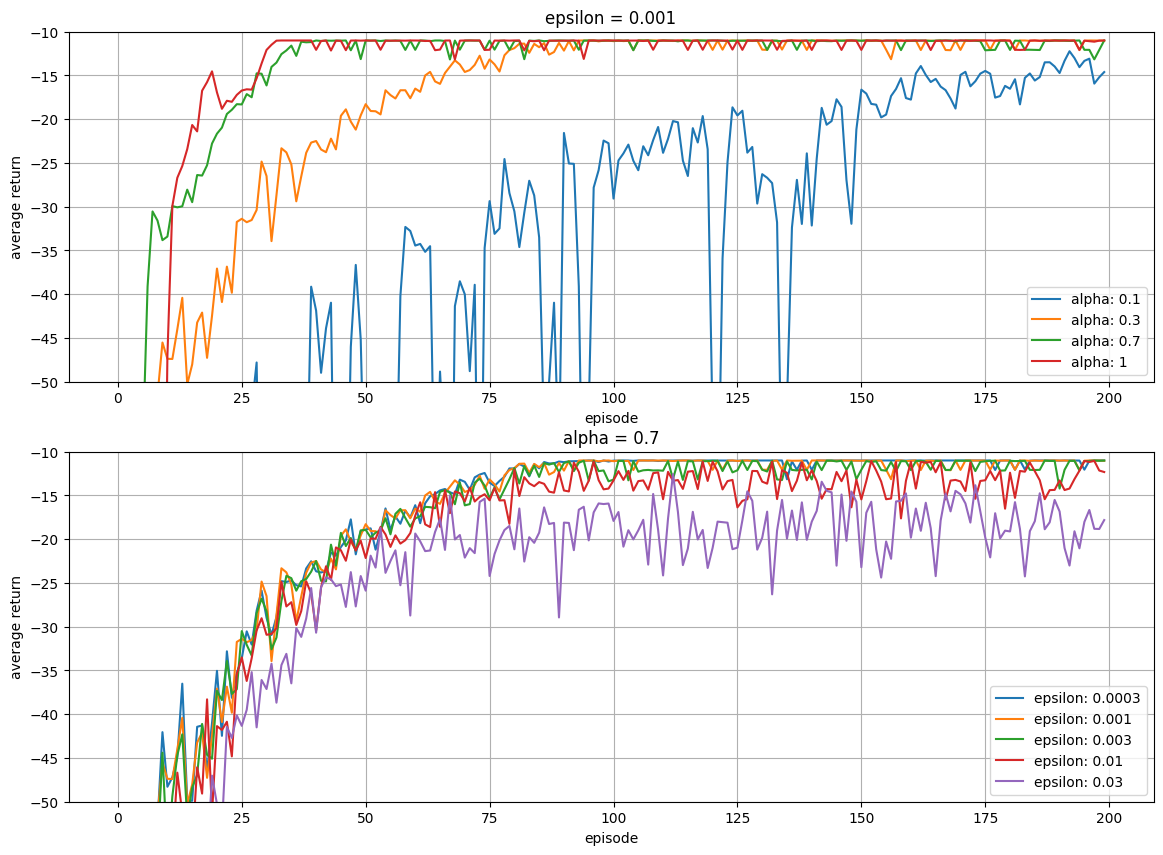

In [4]:
fig, axs = plt.subplots(2, figsize=(14, 10))

for (params, values) in results:
    if params['epsilon'] == 0.001:
        axs[0].plot(np.mean(np.array(values[0]), axis=0), label=f'alpha: {params["alpha"]}')

axs[0].set(xlabel="episode", ylabel="average return", ylim=[-50, -10])
axs[0].grid()
axs[0].legend(loc="lower right")
axs[0].set_title('epsilon = 0.001')

for (params, values) in results:
    if params['alpha'] == 0.3:
        axs[1].plot(np.mean(np.array(values[0]), axis=0), label=f'epsilon: {params["epsilon"]}')

axs[1].set(xlabel="episode", ylabel="average return", ylim=[-50, -10])
axs[1].grid()
axs[1].legend(loc="lower right")
axs[1].set_title('alpha = 0.7')


plt.show()

Just like with Sarsa it seems that high values of $\alpha$ lead to faster learning, while small values of $\epsilon$ are related to a better performance on final rounds.

However unlike SARSA the value of $\epsilon$ doesn't seem to affect the agent prefered policy.

In [5]:
agent = QAgent(
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=0.7,
    epsilon=0.0001,
)

episode_lengths, episode_returns = agent.train(world=small_world_03, episodes=200)
pi_r = get_policy_rec(agent.policy, small_world_03, agent.actions)
print(get_policy_rec_str(pi_r, small_world_03))

 →  →  →  →  ↓  █  ✘ 

 ↓  █  ↑  █  →  →  ↑ 

 ↓  █  ↓  █  █  █  ↑ 

 ↓  █  ←  ☠  →  →  ↑ 

 ←  █  ↑  ☠  ↑  ☠  → 

 →  →  →  →  ↑  ☠  ↓ 




In [6]:
agent = QAgent(
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=0.7,
    epsilon=0.03,
)

episode_lengths, episode_returns = agent.train(world=small_world_03, episodes=200)
pi_r = get_policy_rec(agent.policy, small_world_03, agent.actions)
print(get_policy_rec_str(pi_r, small_world_03))

 →  →  →  →  ↓  █  ✘ 

 ↑  █  ↑  █  →  →  ↑ 

 ↑  █  ←  █  █  █  ↑ 

 ↑  █  ←  ☠  →  →  ↑ 

 ←  █  ↑  ☠  ↑  ☠  ↓ 

 →  →  →  →  ↑  ☠  ↓ 




In this case the agent is learning the greedy path. However a high exploration rate means it will hit the traps very often, which makes the online performance tha much worse for this agents.

## Long Runs

Lets see how the agent performs in a long run

In [7]:
base_arguments = {'reward_function': basic_reward, 'actions': basic_actions}
arguments = {'alpha': [0.1, 0.7], 'epsilon': [0.001, 0.03]}

long_run_results = get_exp_results(QAgent, small_world_03, base_arguments, arguments, 2000, 1)

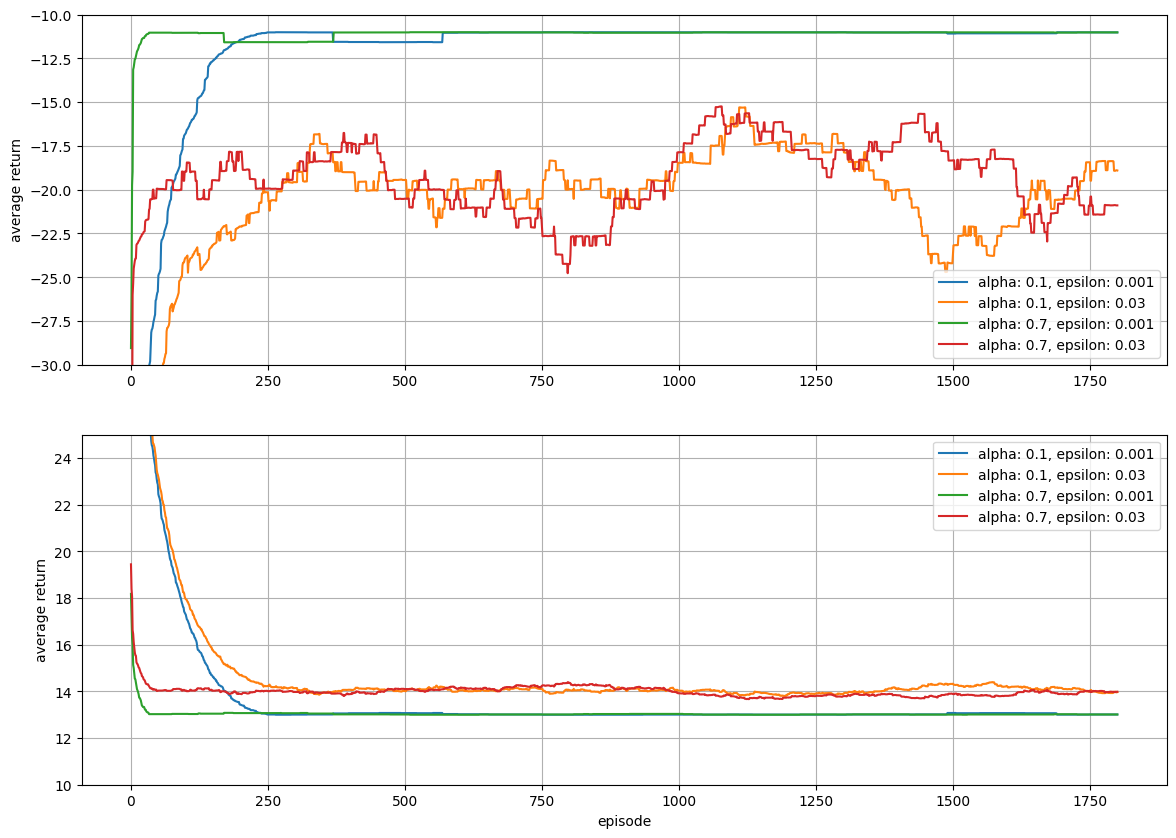

In [8]:
fig, axs = plt.subplots(2, figsize=(14, 10))

for (params, values) in long_run_results:
    v = np.mean(np.array(values[0]), axis=0)
    axs[0].plot(moving_average(v, 200), label=f'alpha: {params["alpha"]}, epsilon: {params["epsilon"]}')

axs[0].set(ylabel="average return", ylim=[-30, -10])
axs[0].grid()
axs[0].legend(loc="lower right")

for (params, values) in long_run_results:
    v = np.mean(np.array(values[1]), axis=0)
    axs[1].plot(moving_average(v, 200), label=f'alpha: {params["alpha"]}, epsilon: {params["epsilon"]}')

axs[1].set(xlabel="episode", ylabel="average return", ylim=[10, 25])
axs[1].grid()
axs[1].legend(loc="upper right")


plt.show()

No surprises here, the agent seems to allways be learning the greedy path, and staying on it. Low values of $\alpha$ make learning go slower, and high values of $\epsilon$ make the final police performance a lot worse. 

## Decaying Parameters

Lets try to correct this by decaying $\epsilon$.

In [9]:
base_arguments = {'reward_function': basic_reward, 'actions': basic_actions, "epsilon_decay": get_exp_decay(decay_lambda = 4e-2, min_value=1e-4)}
arguments = {'alpha': [0.1, 0.7], 'epsilon': [0.001, 0.03]}

decay_results = get_exp_results(QAgent, small_world_03, base_arguments, arguments, 2000, 1)

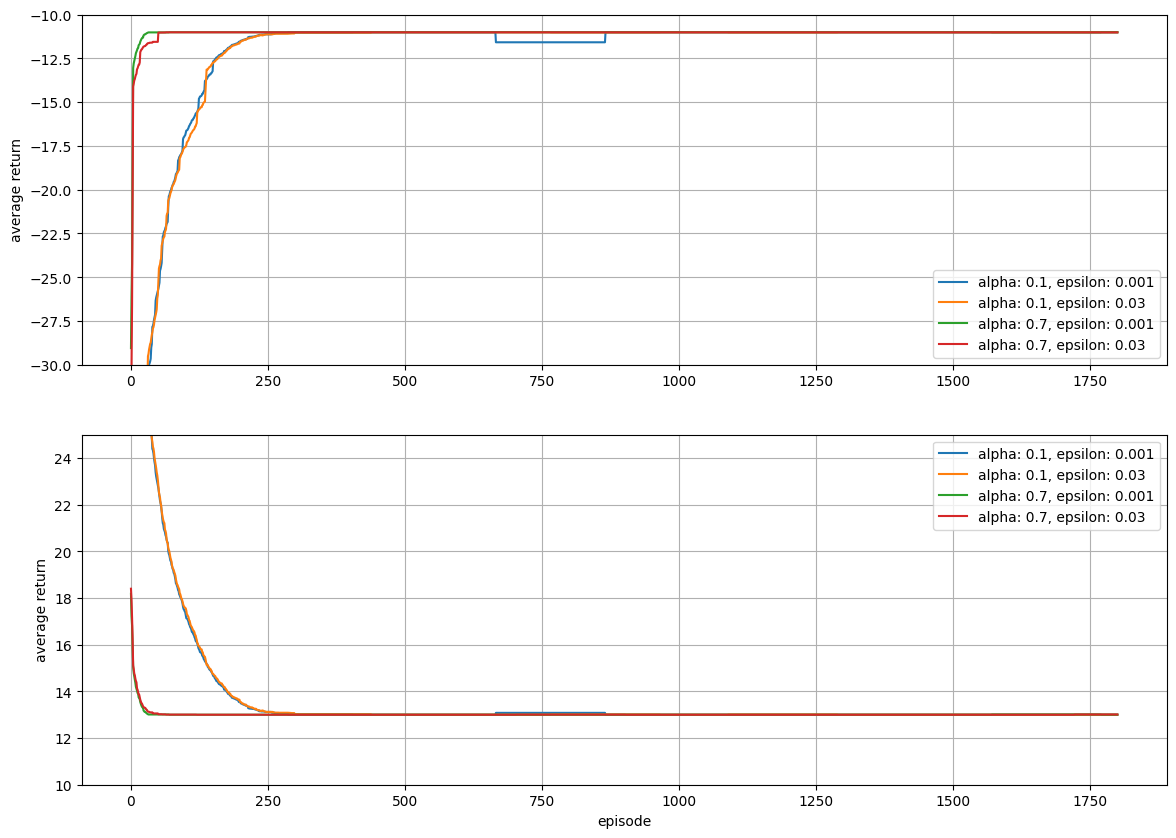

In [10]:
fig, axs = plt.subplots(2, figsize=(14, 10))

for (params, values) in decay_results:
    v = np.mean(np.array(values[0]), axis=0)
    axs[0].plot(moving_average(v, 200), label=f'alpha: {params["alpha"]}, epsilon: {params["epsilon"]}')

axs[0].set(ylabel="average return", ylim=[-30, -10])
axs[0].grid()
axs[0].legend(loc="lower right")

for (params, values) in decay_results:
    v = np.mean(np.array(values[1]), axis=0)
    axs[1].plot(moving_average(v, 200), label=f'alpha: {params["alpha"]}, epsilon: {params["epsilon"]}')

axs[1].set(xlabel="episode", ylabel="average return", ylim=[10, 25])
axs[1].grid()
axs[1].legend(loc="upper right")


plt.show()

This works just as expected, making all policies vey similar in the long run.

An important point here is that the agent is able to figure the greedy path with very little exploration, making a high value of $\epsilon$ kinda useless, in a much more complex problem where a lot of exploration may be required to figure a greedy path this may look very different.

# Large World

The agent is finding the greedy path way too fast, so lets see if we can make things harder for it. This world has a simple, non-greedy solution(going up past the barrier, then towards the goal), where many actions are equivalent; on the other hand it has an opitmal solution which involves a precise path, and deviations from this path can lead to traps or dead ends.

Lets see how the agent performs here.

In [11]:
print(get_world_str(
    large_world_02, 
    show_coordinates = False
))

                                                         

                                                         

                █                                        

                █                                        

                █                          █             

                █                          █             

                █                          █        █  █ 

                █                          █             

                █                    █  █  █     █  █    

                █                    █              █    

                █  █  █              █     █  █     █    

                █     █              ✘              █    

                █     █  █  █  █  █  █  ☠  ☠  ☠     █    

                █              █              ☠     █    

    █  █  █  █  █     ☠  ☠     █     ☠  ☠     ☠     █    

    █                          █     ☠  ☠           █    

    █     █  █     █  █  █     █           ☠     ☠  █   

In [12]:
training_rounds=100
episodes=500

base_arguments = {'reward_function': basic_reward, 'actions': basic_actions}
arguments = {'alpha': [0.3, 0.7], 'epsilon': [0.001, 0.01, 0.1]}

results = get_exp_results(QAgent, large_world_02, base_arguments, arguments, episodes, training_rounds) 

results_df = get_summary_df(results)
display(results_df.round({'average_reward': 2, 'std_reward': 2, 'average_reward_final_10': 2, 'std_reward_final_10': 2}))

,alpha,epsilon,average_round_reward,std_round_reward,average_reward_final_10,std_reward_final_10,shortest_run
3,0.7,0.001,-54670.52,233.317015,-38.08,10.99,39
4,0.7,0.010,-58550.47,730.075550,-49.05,37.66,39
0,0.3,0.001,-87480.06,135.372140,-54.06,20.19,39
1,0.3,0.010,-88930.29,452.294557,-57.22,29.24,39
2,0.3,0.100,-119508.22,2380.544969,-90.16,63.21,39
5,0.7,0.100,-120959.72,4162.265246,-234.63,246.46,39


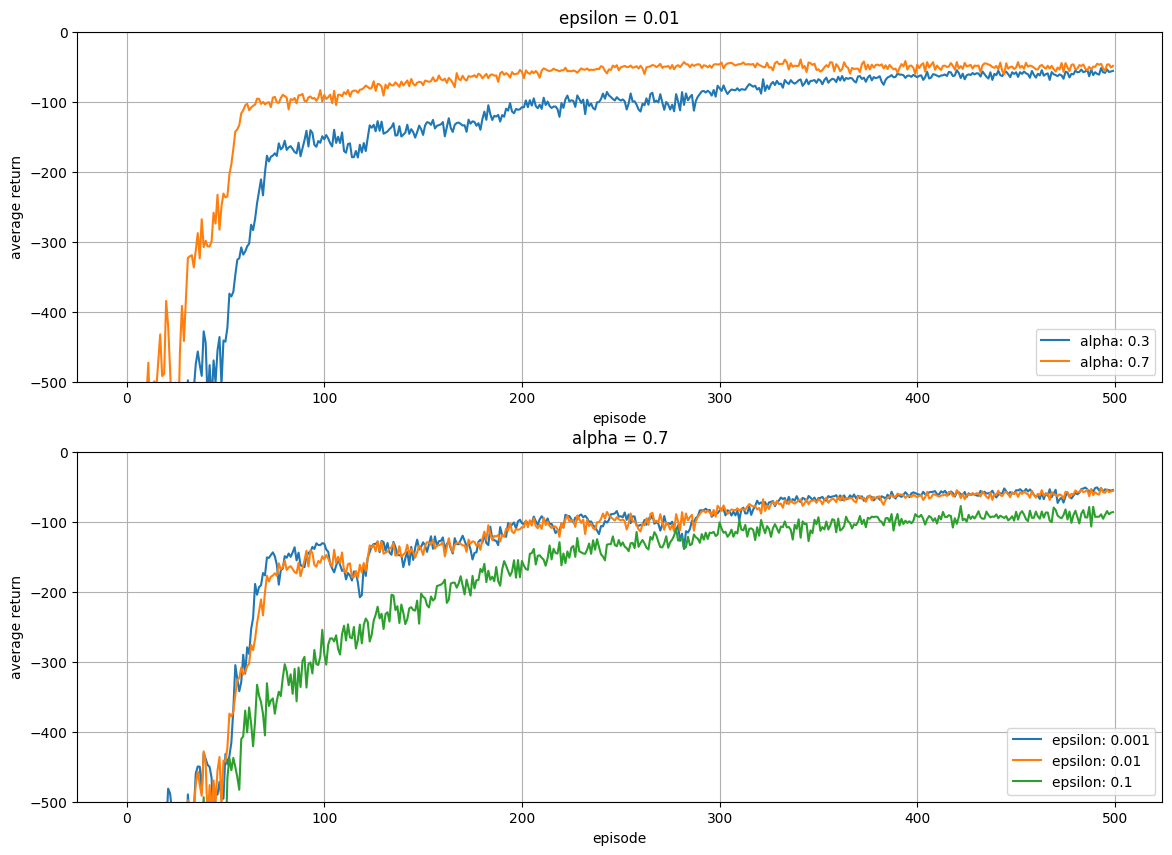

In [13]:
fig, axs = plt.subplots(2, figsize=(14, 10))

for (params, values) in results:
    if params['epsilon'] == 0.01:
        axs[0].plot(np.mean(np.array(values[0]), axis=0), label=f'alpha: {params["alpha"]}')

axs[0].set(xlabel="episode", ylabel="average return", ylim=[-500, 0])
axs[0].grid()
axs[0].legend(loc="lower right")
axs[0].set_title('epsilon = 0.01')

for (params, values) in results:
    if params['alpha'] == 0.3:
        axs[1].plot(np.mean(np.array(values[0]), axis=0), label=f'epsilon: {params["epsilon"]}')

axs[1].set(xlabel="episode", ylabel="average return", ylim=[-500, 0])
axs[1].grid()
axs[1].legend(loc="lower right")
axs[1].set_title('alpha = 0.7')


plt.show()

Pretty impressive results, all agents seem to have figured out the optimal path in at least one of the rounds. Again a high exploration rate seems to hurt the agent more then benefit it. 

Lets take a look at some of the learned policies

In [14]:
agent = QAgent(
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=0.7,
    epsilon=0.1,
)

episode_lengths, episode_returns = agent.train(world=large_world_02, episodes=500)
pi_r = get_policy_rec(agent.policy, large_world_02, agent.actions)
print(get_policy_rec_str(pi_r, large_world_02))

 ↑  →  →  →  →  →  →  →  ↑  →  ↓  ↓  ↓  ↓  →  ↑  ↓  ↑  ↓ 

 ↑  →  →  →  →  →  →  →  ↓  ↓  ↓  ↓  →  ↓  →  ↓  ↓  ↑  ↓ 

 →  →  ↑  →  ↑  █  →  ↓  →  →  →  ↓  ↓  ↓  ↓  ←  ←  ↓  ↑ 

 ↓  →  ↑  ↑  ↑  █  ↓  ↓  ↓  →  ↓  ↓  ↓  →  ↓  ↓  ↓  ↑  → 

 →  ↑  ↑  →  ↑  █  ↓  ↓  ↓  ↓  ↓  ↓  ↓  →  █  ↑  →  →  ↑ 

 →  ↑  ↑  ↑  ↑  █  →  ↓  ↓  →  ↓  ↓  ↓  ↓  █  ↓  ↑  ↓  ↓ 

 ↑  ↑  ←  ↑  ↑  █  ↓  →  ↓  ↓  →  ↓  ↓  →  █  ↓  ↓  █  █ 

 →  →  ↑  ↑  ↑  █  →  →  ↓  →  →  ↓  ←  ←  █  ↓  ←  ←  ← 

 →  ↑  ↑  ↑  ↑  █  ↓  ↓  ↓  ↓  ↓  ↓  █  █  █  ↓  █  █  ↑ 

 ↑  ↑  →  ↑  ↑  █  →  →  ↓  →  →  ↓  █  ↓  ←  ←  →  █  ↑ 

 ↑  ↑  →  ↑  ↑  █  █  █  ↓  →  →  ↓  █  ↓  █  █  ↓  █  ↑ 

 ↑  ↑  →  ↑  ←  █  ↑  █  →  →  →  →  ✘  ←  ←  ←  ←  █  ↑ 

 ↑  ↑  ↓  ↑  ↑  █  ←  █  █  █  █  █  █  ☠  ☠  ☠  ↑  █  ↑ 

 ↑  →  ↑  ←  ↑  █  ↓  ←  ↑  →  █  →  →  →  ↓  ☠  ↑  █  ↑ 

 ↑  █  █  █  █  █  ←  ☠  ☠  ↑  █  ↑  ☠  ☠  ↓  ☠  ↑  █  ↑ 

 ↑  █  →  →  ↓  ↓  ↑  →  →  →  █  ↑  ☠  ☠  →  →  ↑  █  ↑ 

 ↑  █  ↓  █  █  ↓  █  █  █  ←  █  ↑  ←  ←  ☠  ↑  ☠  █  →

In [15]:
agent = QAgent(
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=0.7,
    epsilon=0.001,
)

episode_lengths, episode_returns = agent.train(world=large_world_02, episodes=500)
pi_r = get_policy_rec(agent.policy, large_world_02, agent.actions)
print(get_policy_rec_str(pi_r, large_world_02))

 →  ↓  →  ↑  →  ↓  →  ←  →  →  ↑  ↑  ↓  ↑  ↑  →  ↓  ↑  ← 

 ←  →  →  →  →  →  ↓  →  →  →  →  ↓  ↓  ↓  ↓  ←  →  ↑  ← 

 ↑  →  →  ↑  ↑  █  ↓  →  →  ↓  ↓  ↓  →  →  ↓  ←  →  ←  → 

 →  →  ↑  →  ↑  █  ↓  ↓  ↓  →  ↓  ↓  →  ↓  ↓  ←  ←  →  ↓ 

 ↑  ↑  ↑  ↑  ↑  █  ↓  →  ↓  ↓  ↓  ↓  →  ↓  █  ↑  ↑  ←  ↑ 

 ↑  ↓  ↑  →  ↑  █  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↑  █  →  ↓  ↑  ↓ 

 ↑  →  ↑  ↑  ↑  █  ↓  →  →  →  →  ↓  ←  ←  █  ↓  ←  █  █ 

 ↑  ↑  ↑  ↑  ↑  █  ↓  ↓  →  ↓  →  ↓  ←  ←  █  ↓  ←  ←  ← 

 ↑  ←  ↑  ↑  ↑  █  ↓  →  ↓  ↓  →  ↓  █  █  █  ↓  █  █  ↑ 

 ↑  ↑  →  →  ↑  █  →  →  →  →  →  ↓  █  ↓  ←  ←  ↑  █  ↑ 

 ↑  ↑  ←  ↑  ↑  █  █  █  →  →  ↓  ↓  █  ↓  █  █  ↓  █  ↑ 

 ↑  →  →  ↑  ↑  █  ←  █  →  →  →  →  ✘  ←  ←  ←  ←  █  ↑ 

 ↑  →  →  →  ↑  █  ←  █  █  █  █  █  █  ☠  ☠  ☠  ↑  █  ↑ 

 →  ↑  →  ↓  ↑  █  ←  ↑  ↑  →  █  →  →  →  ↓  ☠  ↑  █  ↑ 

 ↑  █  █  █  █  █  ←  ☠  ☠  ↓  █  ↑  ☠  ☠  ↓  ☠  ↑  █  ↑ 

 ↑  █  ↑  ↑  →  ↓  →  →  →  ↓  █  ↑  ☠  ☠  →  →  ↑  █  ↑ 

 ↑  █  ↓  █  █  ↑  █  █  █  ↓  █  ↑  ←  ←  ☠  ↓  ☠  █  ↑

In [16]:
print(f"all states: {len(agent.visited_states)}, visited states: {len(large_world_02.states)}")

all states: 291, visited states: 291


Both policies seem pretty good, even in the longer path. One difference is that the policy with higher $\epsilon$ learned to "get back" to the main path when it deviates, while the other didn't. This is not surprising, as the one with lower $\epsilon$ is much less likely to get out of the path in the first place.

## Conclusion

Much like SARSA The agent is clearly capable of finding a solution for this problem. The parameters have a significant impact, for this particular problem it seems like:

* high values of $\alpha$ lead to fast learning
* the agent seems pretty capable of finding the greedy path
* high value of $\epsilon$ lead to poor online performance; decaying this paramater improved performance

Curiously for this algorithm, in this particular problem, exploration(in the sense of taking non-greedy actions) doesn't seem to be all that important. This may have a lot to do with the way we setted our reward function, since the negative reward the agent receives after each action will make it reavaluate its policy quite often, which in turn will make it "explore"(in the sense of taking different actions then previously) lots of states naturally(as we can see above).